In [54]:
import pickle
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap, Normalize
from matplotlib.ticker import StrMethodFormatter
from matplotlib.cm import ScalarMappable
from matplotlib import rcParams

# Load and parse data

In [55]:
def load_results():
    results = {}
    results_dir = Path('results')
    for dataset_results_dir in results_dir.iterdir():
        dataset_results = {}
        for dataset_results_path  in dataset_results_dir.iterdir():
            with open(dataset_results_path, 'rb') as handle:
                dataset_results = {**dataset_results, **pickle.load(handle)}
        results[dataset_results_dir.stem] = dataset_results
    return results

ALPHAS = np.array([0.9, 0.99, 0.999, 0.9999, 0.99999])
BETAS = np.array([0.1, 0.3, 0.5, 0.7, 0.9])
ETAS = np.array([0.1, 0.3, 0.5, 0.7, 0.9])
RESULTS = load_results()

def parse_results(dataset_name, beta, metric):
    values = np.zeros((ALPHAS.size, ETAS.size), dtype=float)
    data = {(alpha, eta): d for (alpha, b, eta), d in RESULTS[dataset_name].items() if b == beta}
    
    for (alpha, eta), res in data.items():
        j = np.argwhere(ALPHAS==alpha)[0,0]
        i = np.argwhere(ETAS==eta)[0,0]
        
        if metric == 'min':
            min_losses = [min(d['losses']) for d in res.values()]
            loss = np.log(np.mean(min_losses))
        elif metric == 'last':
            last_losses = [d['losses'][-1] for d in res.values()]
            loss = np.log(np.mean(last_losses))
        values[i, j] = loss
    return values

# Find optimal configuration for each dataset

In [56]:
for dataset_name, data in RESULTS.items():
    min_loss = np.inf
    min_loss_std = None
    last_loss = None
    last_loss_std = None
    opt_conf = None
    for c, res in data.items():
        c_min_losses = [min(d['losses']) for d in res.values()]
        c_min_loss = np.mean(c_min_losses)
        
        if c_min_loss < min_loss:
            opt_conf = c
            min_loss = c_min_loss
            min_loss_std = np.std(c_min_losses)
            c_last_losses = [d['losses'][-1] for d in res.values()]
            last_loss = np.mean(c_last_losses)
            last_loss_std = np.std(c_last_losses)
    
    print(f'\n{dataset_name}')
    print(f'Opt conf:  {opt_conf}')
    print(f'Min loss:  {round(min_loss, 3)} +- {round(min_loss_std, 3)}')
    print(f'Last loss: {round(last_loss, 3)} +- {round(last_loss_std, 3)}')


20newsgroups
Opt conf:  (0.99999, 0.1, 0.1)
Min loss:  5.497 +- 0.005
Last loss: 5.497 +- 0.005

amlall
Opt conf:  (0.9999, 0.1, 0.5)
Min loss:  0.802 +- 0.007
Last loss: 0.804 +- 0.007

curet
Opt conf:  (0.99999, 0.1, 0.9)
Min loss:  2.49 +- 0.023
Last loss: 2.491 +- 0.023

dolphins
Opt conf:  (0.99999, 0.7, 0.7)
Min loss:  1.602 +- 0.007
Last loss: 1.603 +- 0.007

football
Opt conf:  (0.99999, 0.7, 0.9)
Min loss:  0.842 +- 0.034
Last loss: 0.844 +- 0.034

gisette
Opt conf:  (0.99999, 0.3, 0.1)
Min loss:  5.406 +- 0.032
Last loss: 5.407 +- 0.032

iris
Opt conf:  (0.9999, 0.7, 0.1)
Min loss:  2.139 +- 0.046
Last loss: 2.143 +- 0.047

wine
Opt conf:  (0.99999, 0.5, 0.3)
Min loss:  2.383 +- 0.032
Last loss: 2.384 +- 0.032


# Plot data

In [57]:
# Matplotlib font configuration
rcParams['font.size'] = 16
rcParams['font.weight'] = 'normal'
rcParams['font.family'] = 'serif'
rcParams['text.usetex'] = True

# Matplotlib color map
cmap = LinearSegmentedColormap.from_list('mycmap', ['#00429d', '#4771b2', '#73a2c6', '#a5d5d8', '#ffffe0', 
                                                    '#ffbcaf', '#f4777f', '#cf3759', '#93003a'])

def plot(dataset_name, beta, metric):
    """Plot heatmap"""
    values = parse_results(dataset_name, beta, metric)
    fig, ax = plt.subplots(figsize=(4.5, 3.5))
    mappable = ax.imshow(values, cmap=cmap, aspect='auto', interpolation='none', origin='lower')

    # Format color bar
    cbar = fig.colorbar(mappable=mappable, ax=ax, pad=0.02)
    cbar.ax.yaxis.set_label_text(r'$\ln{(L_{I})}$')
    cbar.ax.yaxis.set_label_coords(5, 0.51)
    cbar.ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.1f}'))

    # Format x-axis
    ax.xaxis.set_ticks(np.arange(0, ALPHAS.shape[0]))
    x_labels = ALPHAS
    ax.xaxis.set_ticklabels(x_labels, rotation=30)
    ax.xaxis.set_label_text(r'$\alpha$')
    ax.xaxis.set_label_coords(0.5, -0.22)

    # Format y-axis
    ax.yaxis.set_ticks(np.arange(0, ETAS.shape[0]))
    y_labels = ETAS
    ax.yaxis.set_ticklabels(y_labels)
    ax.yaxis.set_label_text(r'$\eta$', rotation=0)
    ax.yaxis.set_label_coords(-0.2, 0.47)
    
    # Annotate heatmap
    kw = {'horizontalalignment': 'center', 'verticalalignment': 'center'}
    intvl = values.max() - values.min()
    max_threshold = values.min() + 0.85 * intvl
    min_threshold = values.min() + 0.15 * intvl
    for i in range(values.shape[0]):
        for j in range(values.shape[1]):
            white = values[i, j] > max_threshold or values[i, j] < min_threshold
            textcolor = 'w' if white else 'k'
            kw.update(color=textcolor)
            value = '{0:.2f}'.format(values[i, j])
            ax.text(j, i, value, **kw)

    # Save figure as pdf
    title = f'{dataset_name}-{metric}-{beta}'
    fig.savefig(f"figs/{title}.pdf".lower(), bbox_inches='tight')
    
    ax.set_title(title)
    plt.show()

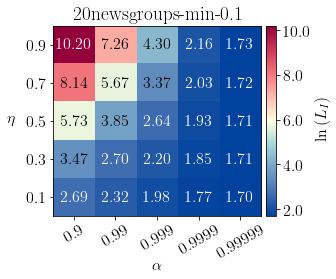

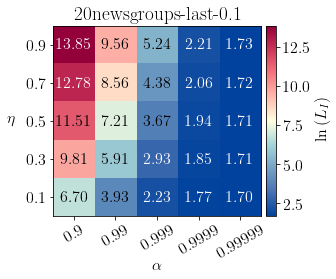

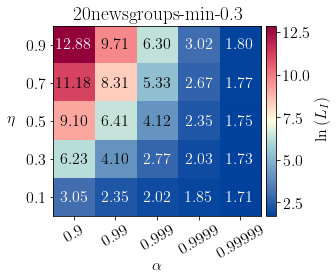

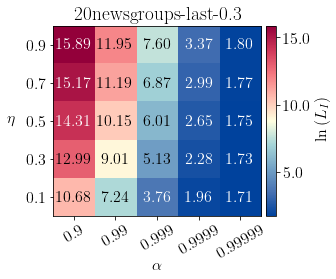

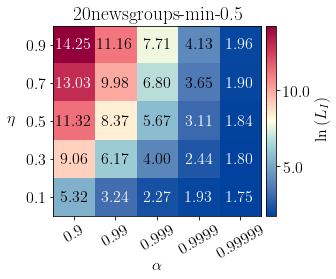

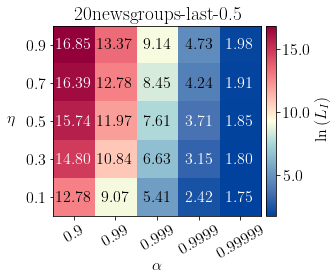

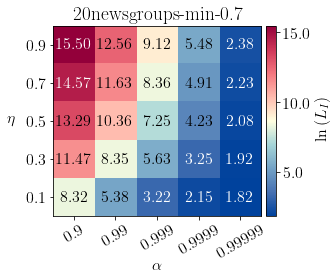

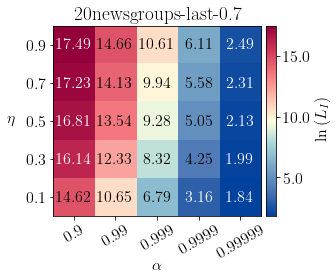

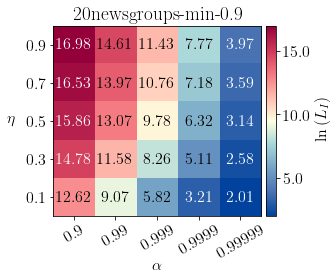

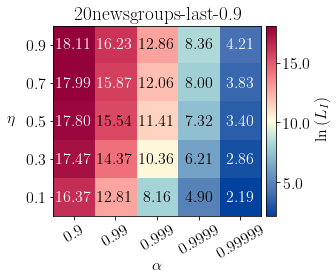

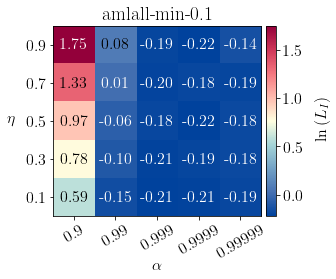

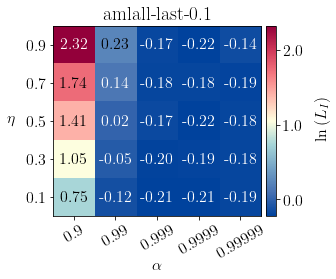

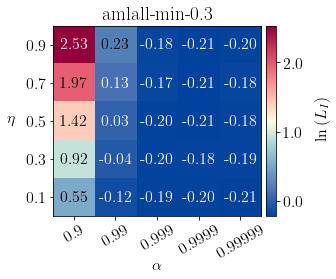

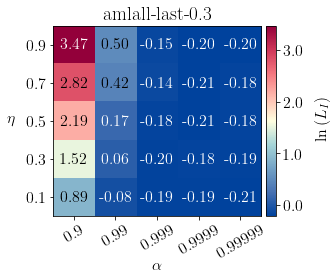

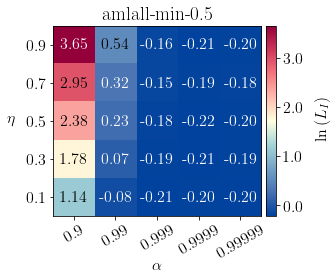

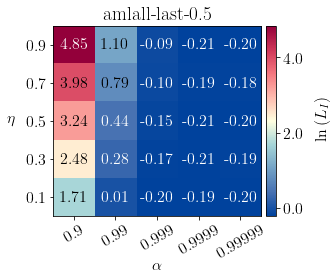

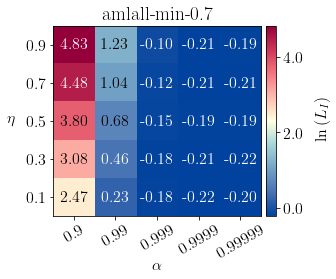

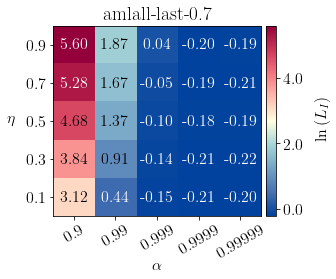

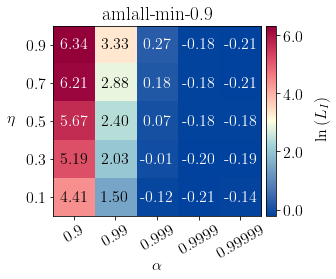

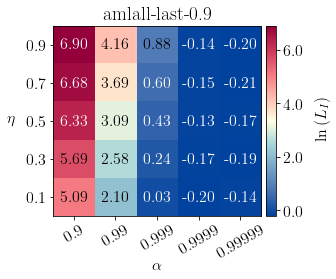

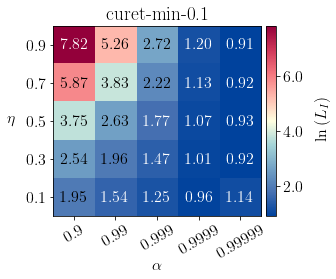

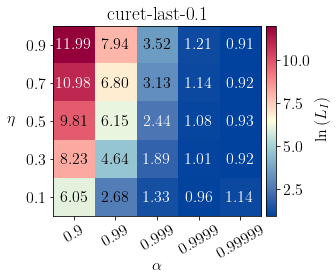

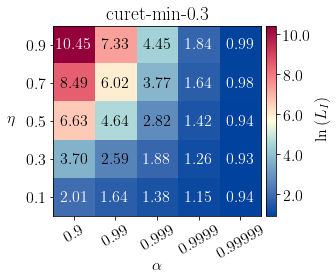

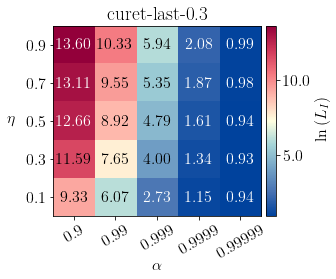

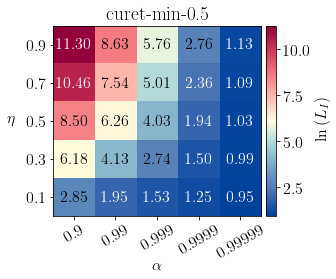

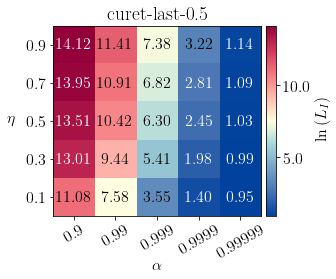

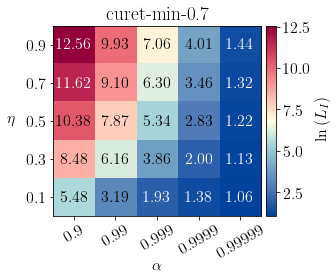

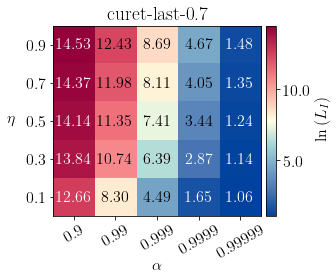

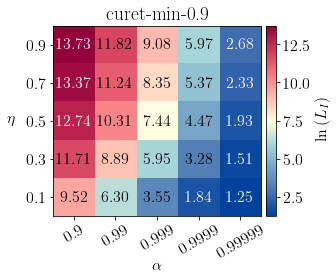

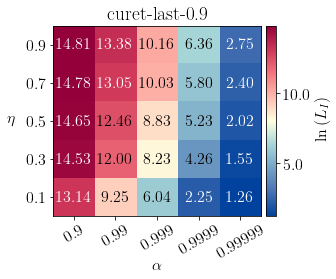

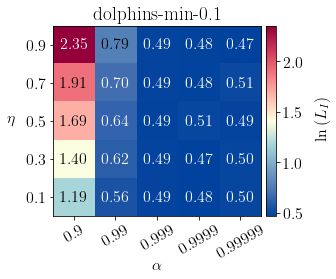

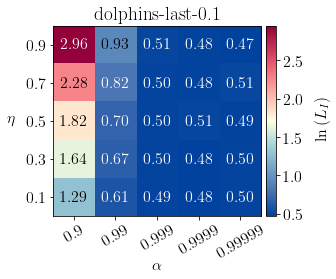

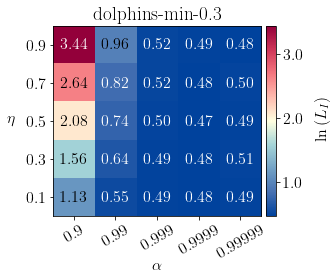

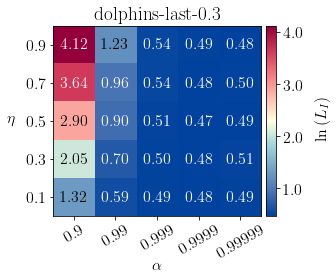

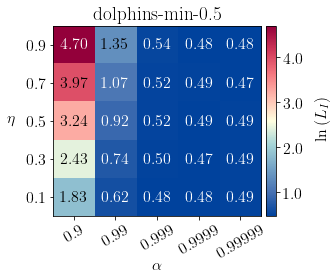

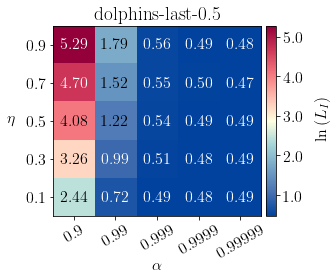

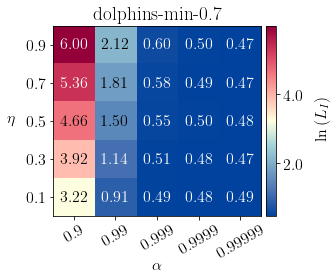

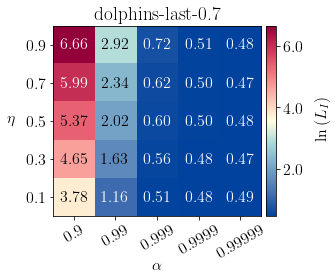

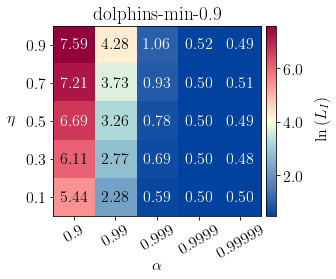

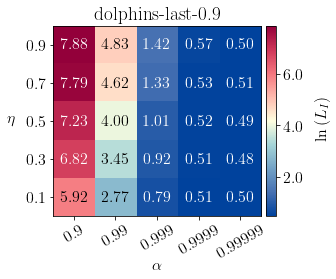

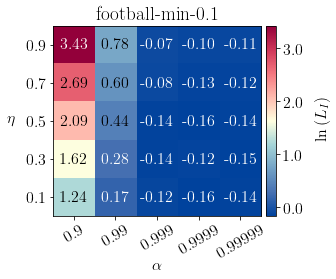

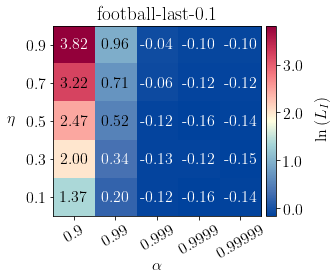

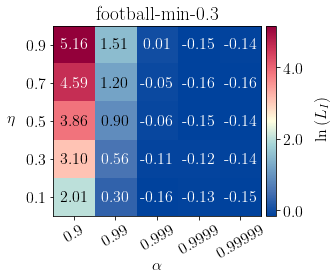

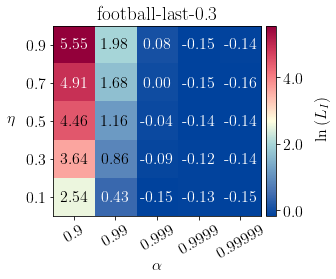

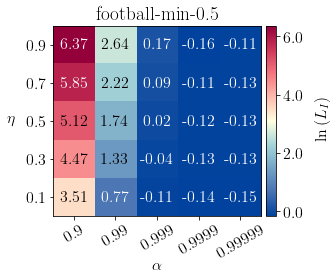

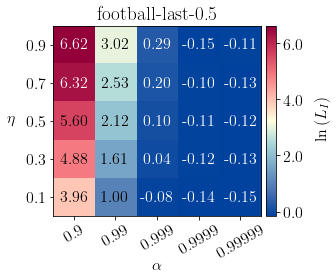

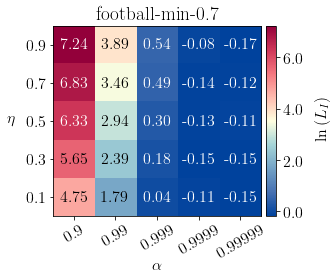

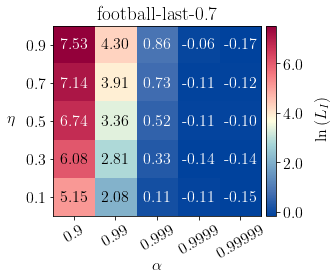

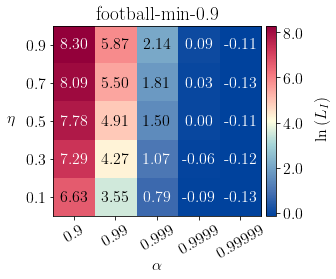

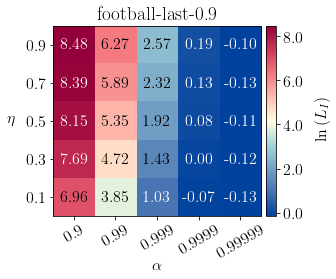

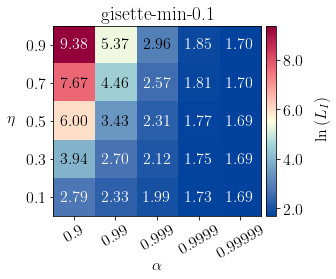

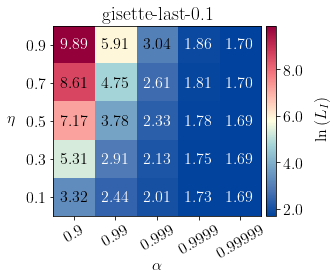

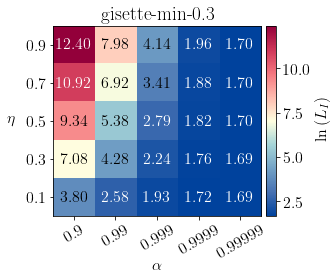

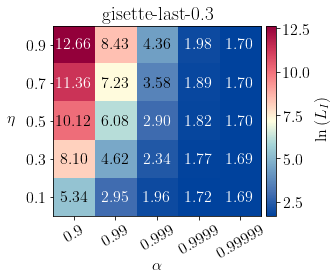

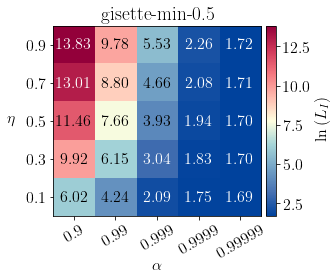

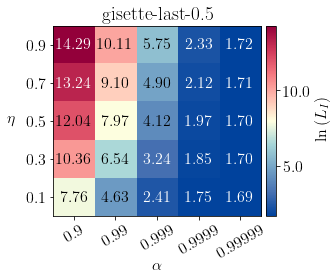

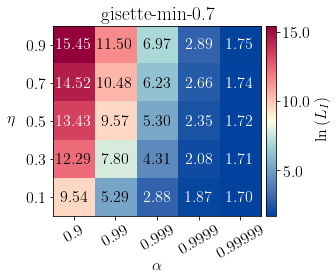

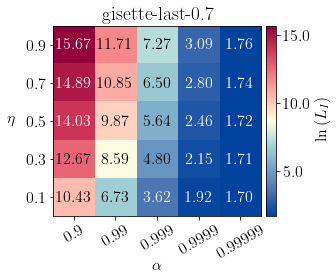

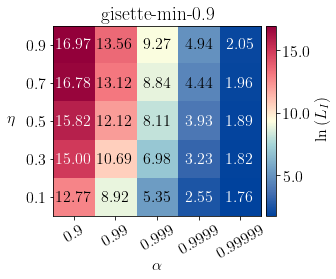

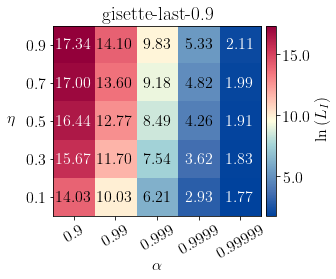

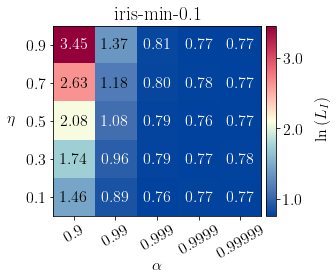

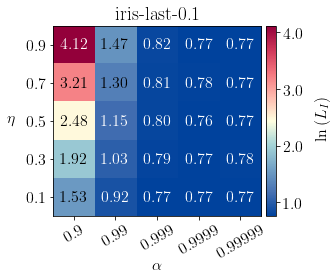

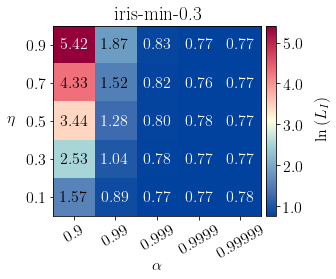

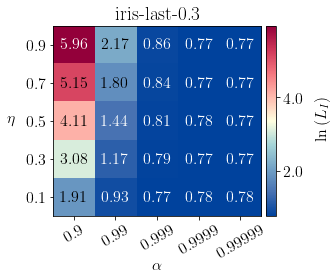

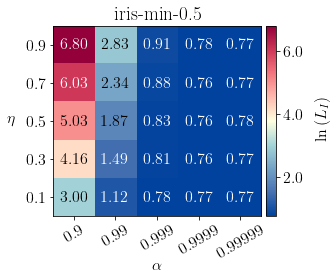

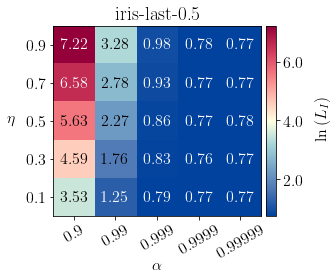

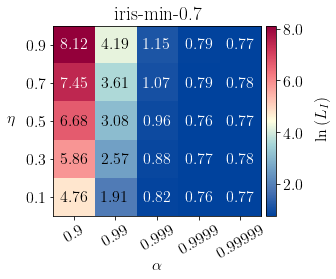

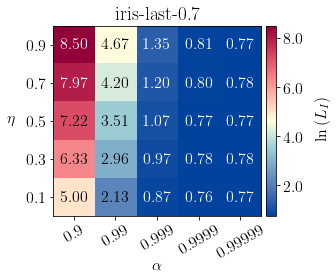

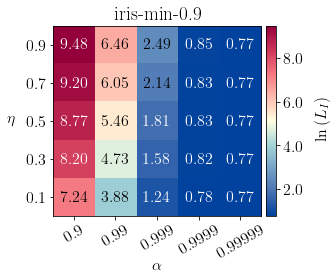

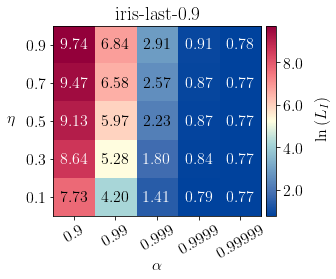

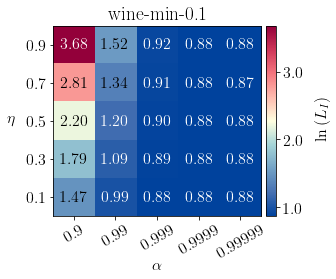

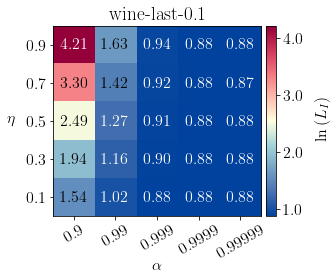

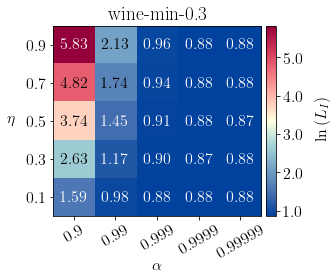

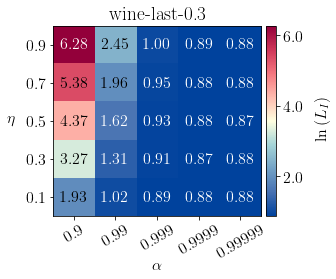

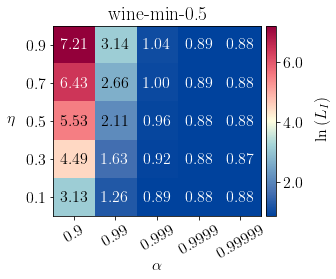

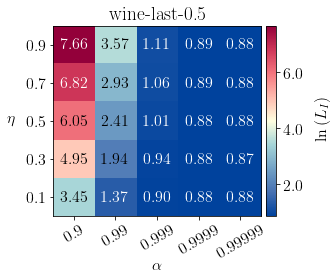

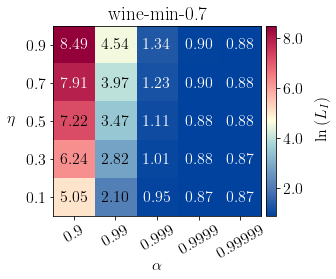

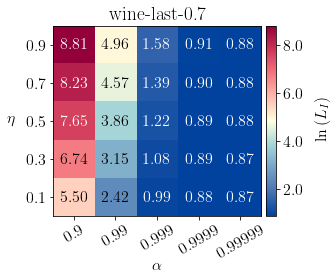

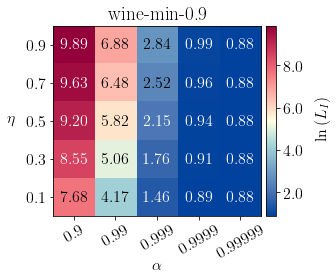

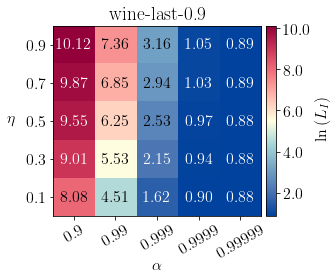

In [58]:
for dataset_name in RESULTS.keys():
    for beta in BETAS:
        plot(dataset_name, beta, 'min')
        plot(dataset_name, beta, 'last')